In [1]:
import sys
import os

global_data_path = 'C:/Users/jaulab/Desktop/AAD/Data'
global_path = 'C:/Users/jaulab/Desktop/deepAAD_project'
# global_data_path = 'D:/AAD_EEG/Data'

# Include parent dir
SCRIPT_DIR = os.path.dirname(os.path.abspath('play.ipynb'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

In [2]:
import numpy as np
import torch
# Definición funciones para trabajar simpre en float32 con numpy y pytorch
def to_numpy(tensor):
    return tensor.detach().cpu().numpy().astype(np.float32)
def to_tensor(array):
    return torch.tensor(array, dtype=torch.float32)

## GRADIENT SAVING

### GRADIENT CONFORMER COMPUTATION

In [52]:
from models.eeg_conformer import Conformer, ConformerConfig

In [53]:
mdl = Conformer(ConformerConfig)

Number of parameters: 0.41M


In [54]:
mdl.apply(mdl.init_weights)

c:\Users\jaulab\Desktop\deepAAD_project\models\eeg_conformer.py:271: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight, mode= 'fan_out', nonlinearity='relu')


Conformer(
  (embed): PatchEmbedding(
    (shallownet): ModuleList(
      (0): Conv2d(1, 40, kernel_size=(1, 8), stride=(1, 1))
      (1): Conv2d(40, 40, kernel_size=(64, 1), stride=(1, 1))
      (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 20), stride=(1, 4), padding=0)
      (5): Dropout(p=0.4, inplace=False)
    )
    (projection): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
  )
  (encoder): TransformerEncoder(
    (0): EncoderBlock(
      (ln_1): LayerNorm()
      (attn): TemporalSelfAttention(
        (w_q): Linear(in_features=40, out_features=40, bias=True)
        (w_k): Linear(in_features=40, out_features=40, bias=True)
        (w_v): Linear(in_features=40, out_features=40, bias=True)
        (c_proj): Linear(in_features=40, out_features=40, bias=True)
        (attn_dropout): Dropout(p=0.4, inplace=False)
        (resid_dropout): Dropout(p=0.4, inplace=False)
      )
   

In [55]:
x = torch.randn((64, 64, 128))
target = torch.randn(64)
logits, loss = mdl(x, target)
logits.shape, loss

(torch.Size([64]), tensor(0.0422, grad_fn=<NegBackward0>))

In [56]:
loss.backward()

In [57]:
for name, param in mdl.named_parameters():
    if param is not None:
        print(f'Layer {name}: {param.grad}')

Layer embed.shallownet.0.weight: tensor([[[[-1.1589e-01, -1.5722e-01, -1.4105e-01, -1.7125e-01, -1.8921e-01,
           -1.4967e-01, -2.0296e-01, -2.3040e-01]]],


        [[[-8.7813e-02, -7.5573e-02, -8.4988e-02, -4.3029e-02, -2.5184e-02,
           -1.1964e-02, -5.2214e-02, -4.5621e-02]]],


        [[[ 1.7741e-02,  1.9373e-02,  4.6946e-02,  5.7790e-02,  7.1441e-02,
            1.4077e-01,  9.1989e-02,  1.0884e-01]]],


        [[[ 9.3034e-02,  7.0245e-02, -3.6819e-05,  4.3412e-03,  9.4979e-02,
            1.1864e-01,  6.5652e-02,  1.2992e-01]]],


        [[[-1.6778e-01, -1.4607e-01, -1.6653e-01, -3.4871e-02,  3.6625e-02,
            7.3078e-02,  7.1132e-02,  4.2567e-02]]],


        [[[-4.3703e-02, -1.1809e-01, -3.7278e-02, -1.0814e-01, -3.8427e-02,
           -7.2157e-02, -4.8850e-02, -8.6604e-02]]],


        [[[ 1.5178e-02,  3.9372e-02, -3.1354e-02, -1.9728e-02,  9.2279e-02,
           -3.2841e-03,  3.6951e-02, -5.6273e-02]]],


        [[[-3.9252e-02, -4.3034e-02, -2.0035e-02, 

In [58]:
from torch.utils.tensorboard import SummaryWriter

In [59]:
writer = SummaryWriter()

In [60]:
for name, param in mdl.named_parameters():
    if param is not None:
        # SAVING NAME, GRAD, EPOCH
        writer.add_histogram(f'{name}.grad', param.grad, 1)

### WANDB GRADIENT SAVING

In [61]:
import wandb

In [62]:
wandb.init(project='gradient_tracking')

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,0


In [46]:
for name, param in mdl.named_parameters():
    if param.grad is not None and 'bias' not in name:
        # detach that eliminates property of the tensor of requiring grad
        wandb.log({f"{name}_grad": wandb.Histogram(param.cpu().detach().numpy()), "epoch": 0}) 

In [47]:
for name, param in mdl.named_parameters():
    if param.grad is not None and 'bias' not in name:
        print(name)

embed.shallownet.0.weight
embed.shallownet.1.weight
embed.shallownet.2.weight
embed.projection.weight
encoder.0.ln_1.weight
encoder.0.attn.w_q.weight
encoder.0.attn.w_k.weight
encoder.0.attn.w_v.weight
encoder.0.attn.c_proj.weight
encoder.0.ln_2.weight
encoder.0.mlp.c_fc.weight
encoder.0.mlp.c_proj.weight
encoder.1.ln_1.weight
encoder.1.attn.w_q.weight
encoder.1.attn.w_k.weight
encoder.1.attn.w_v.weight
encoder.1.attn.c_proj.weight
encoder.1.ln_2.weight
encoder.1.mlp.c_fc.weight
encoder.1.mlp.c_proj.weight
classif.fc.0.weight
classif.fc.3.weight
classif.fc.6.weight


In [49]:
desired_layers = ['classif.fc.0.weight', 
                  'classif.fc.6.weight', 
                  'embed.shallownet.0.weight',
                  'embed.shallownet.2.weight',
                  'encoder.0.attn.w_q.weight',
                  'encoder.3.attn.w_q.weight',
                  'encoder.0.mlp.c_fc.weight',
                  'encoder.3.mlp.c_fc.weight',
                ]

In [50]:
for name, param in mdl.named_parameters():
    if param.grad is not None and name in desired_layers:
        # detach that eliminates property of the tensor of requiring grad
        wandb.log({f"{name}_grad": wandb.Histogram(param.cpu().detach().numpy()), "epoch": 0}) 

### WANDB WATCH

In [4]:
from utils.datasets import CustomDataset
from utils.functional import get_data_path
from torch.utils.data import DataLoader

In [5]:
data_path = get_data_path('C:/Users/jaulab/Desktop/AAD/Data', 'fulsang', filt=False)
dataset = CustomDataset('fulsang', data_path, 'train', 'S1', 128, 1)

In [6]:
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
mdl.to(device)
optimizer = torch.optim.Adam(mdl.parameters(), lr=1e-06, weight_decay = 1e-04)

NameError: name 'mdl' is not defined

In [88]:
import tqdm

In [91]:
wandb.init(project='gradient_tracking')
wandb.watch(models = mdl, log='all', log_freq=len(data_loader))

max_epoch = 5

for epoch in range(max_epoch):

    tqdm_loader = tqdm.tqdm(data_loader, desc=f'Epoch: {epoch}', leave = False, mininterval=0.5)
    
    epoch_losses = []

    for batch_idx, data in enumerate(tqdm_loader):

        eeg = data['eeg'].to(device, dtype=torch.float)
        stima = data['stima'].to(device, dtype=torch.float)

        preds, loss = mdl(eeg, targets = stima)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss)

    print(f'loss: {torch.mean(loss).item()}')
    wandb.log({'train_loss': -torch.mean(loss).item()})

loss: -0.10746944695711136


loss: -0.03581579402089119


loss: 0.10303233563899994


loss: -0.17529068887233734


loss: 0.03303400054574013


loss: -0.12475737184286118


loss: -0.01291625201702118


KeyboardInterrupt: 

In [4]:
from models.dnn import FCNN, CNN

In [10]:
mdl = FCNN(n_hidden=3)

In [6]:
mdl = CNN()

In [11]:
for layer, param in mdl.named_parameters():
    print(layer)

model.1.weight
model.1.bias
model.4.weight
model.4.bias
model.7.weight
model.7.bias
model.10.weight
model.10.bias


In [9]:
x = torch.randn((64,64,50))
preds, loss = mdl(x)
preds.shape, loss

(torch.Size([64]), None)

### REPRODUCIBILITY DATALOADER

In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [17]:
x = torch.arange(40).view(-1, 1)
x.shape

torch.Size([40, 1])

In [18]:
dataset = TensorDataset(x)
dataloader = DataLoader(dataset, num_workers=2, shuffle=True, batch_size = 10)

In [19]:
torch.manual_seed(2809)
for data in dataloader:
    print(data)

[tensor([[28],
        [ 8],
        [18],
        [14],
        [ 0],
        [22],
        [13],
        [ 5],
        [15],
        [ 3]])]
[tensor([[30],
        [32],
        [39],
        [25],
        [16],
        [34],
        [ 9],
        [ 6],
        [38],
        [29]])]
[tensor([[10],
        [ 7],
        [17],
        [ 2],
        [12],
        [ 1],
        [37],
        [36],
        [31],
        [11]])]
[tensor([[26],
        [19],
        [21],
        [ 4],
        [35],
        [23],
        [27],
        [20],
        [33],
        [24]])]


In [22]:
torch.manual_seed(2809)
for data in dataloader:
    print(data, len(data))

[tensor([[28],
        [ 8],
        [18],
        [14],
        [ 0],
        [22],
        [13],
        [ 5],
        [15],
        [ 3]])] 1
[tensor([[30],
        [32],
        [39],
        [25],
        [16],
        [34],
        [ 9],
        [ 6],
        [38],
        [29]])] 1
[tensor([[10],
        [ 7],
        [17],
        [ 2],
        [12],
        [ 1],
        [37],
        [36],
        [31],
        [11]])] 1
[tensor([[26],
        [19],
        [21],
        [ 4],
        [35],
        [23],
        [27],
        [20],
        [33],
        [24]])] 1


## DATA VISUALIZATION

In [3]:
SCRIPT_DIR

'c:\\Users\\jaulab\\Desktop\\deepAAD_project\\notebooks'

In [12]:
import mne
import numpy as np
from utils.datasets import CustomDataset
from utils.functional import get_data_path
import scipy
import os
import torch
global_path = 'C:/users/jaulab/Desktop'
import matplotlib.pyplot as plt

In [5]:
%matplotlib widget

### EEG MNE VISUALIZATION

In [9]:
# Leer datos npy
data_path = get_data_path(os.path.join(global_path, 'AAD', 'Data'), 'fulsang')
dataset = CustomDataset('fulsang', data_path, 'train', 'S1', window=128, hop=8)

In [10]:
# Leer datos mat
data_path = get_data_path(os.path.join(global_path, 'AAD', 'Data'), 'fulsang')
dataset = CustomDataset('fulsang', data_path, 'train', 'S1', window=128, hop=8, data_type = 'mat')

In [11]:
# Leer datos directamente DATA_preproc.mat
from utils.functional import normalize_eeg
preproc_data = scipy.io.loadmat(os.path.join(data_path ,'S1_data_preproc.mat'))
eeg_data = np.transpose(preproc_data['data']['eeg'][0,0][0,0])[:64, :]
stima_data = np.squeeze(preproc_data['data']['wavA'][0,0][0,0])
eeg_data = normalize_eeg(torch.tensor(eeg_data))

In [12]:
eeg_data = dataset.eeg
eeg_data.shape

torch.Size([64, 153600])

In [13]:
# Nombre canales
subj = 'S1'
eeg_path = os.path.join(global_path, 'AAD', 'Fulsang', 'EEG')
data = scipy.io.loadmat(os.path.join(eeg_path, subj+'.mat'))
channel_names = data['data'][0,0]['dim'][0,0]['chan'][0,0]['eeg'][0,0]
channel_names = [chan[0].item() for chan in channel_names][:64]
channel_names[:5]

['Fp1', 'AF7', 'AF3', 'F1', 'F3']

In [19]:
channel_types = ['eeg'] * eeg_data.shape[0]

In [20]:
fs = 64
# fs = 125
eeg_info = mne.create_info(channel_names, sfreq=fs, ch_types=channel_types)
raw = mne.io.RawArray(eeg_data, eeg_info)
raw.info

Creating RawArray with float64 data, n_channels=64, n_times=153600
    Range : 0 ... 153599 =      0.000 ...  2399.984 secs
Ready.


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 32.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 64.0 Hz
>

In [21]:
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 32.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 64.0 Hz
>

Effective window size : 32.000 (s)
Plotting power spectral density (dB=True).


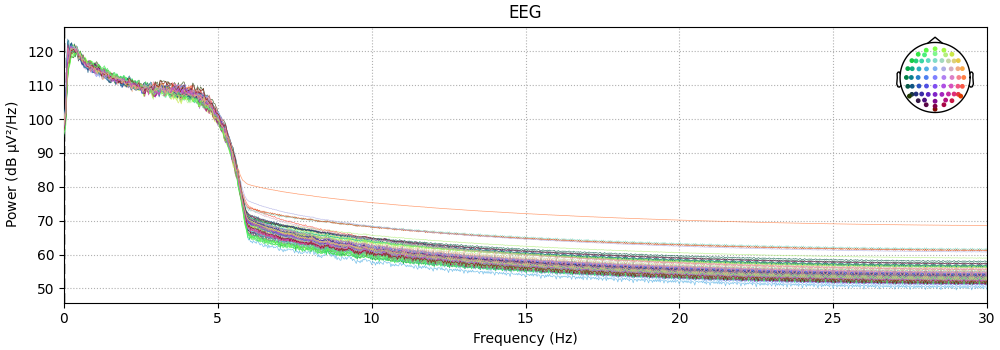

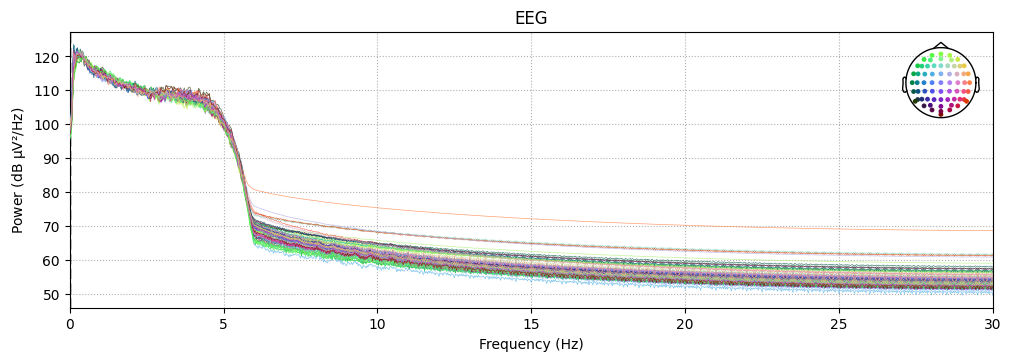

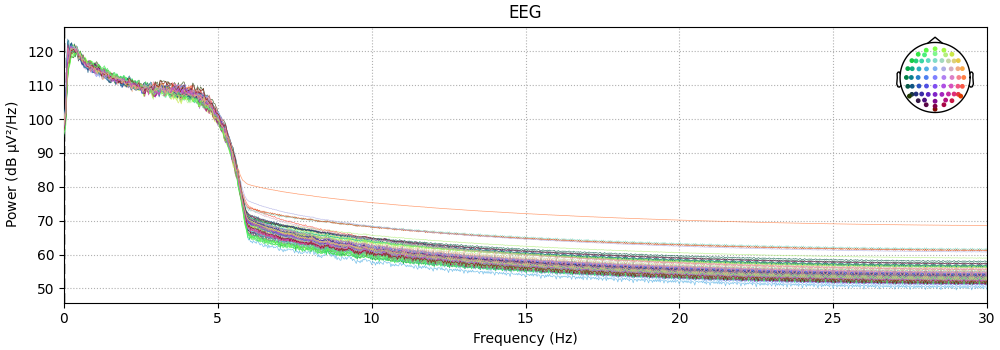

In [22]:
raw.compute_psd(fmax=30).plot(picks="data", exclude="bads", amplitude=False)

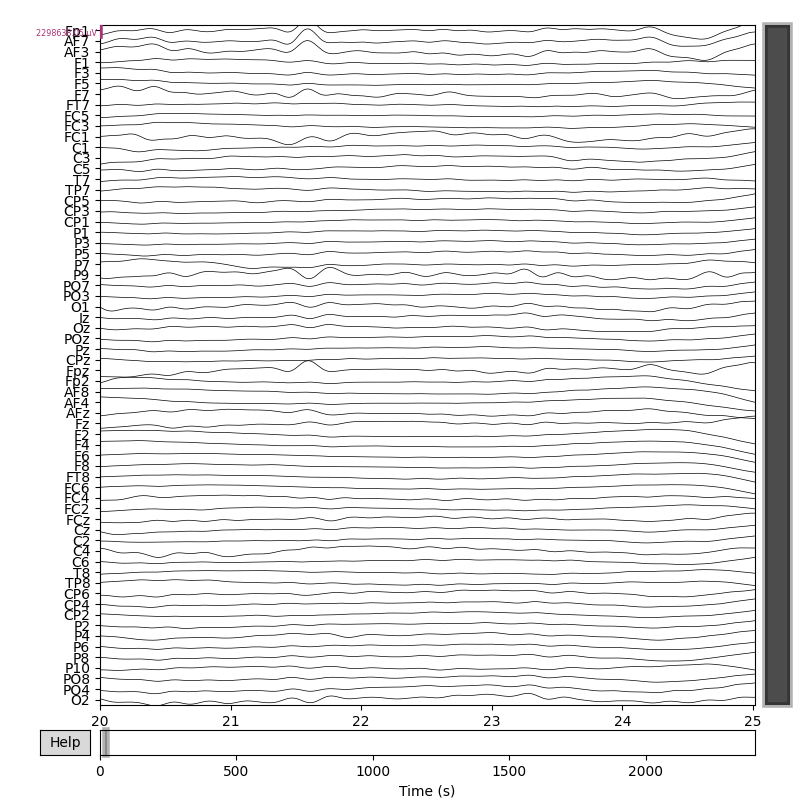

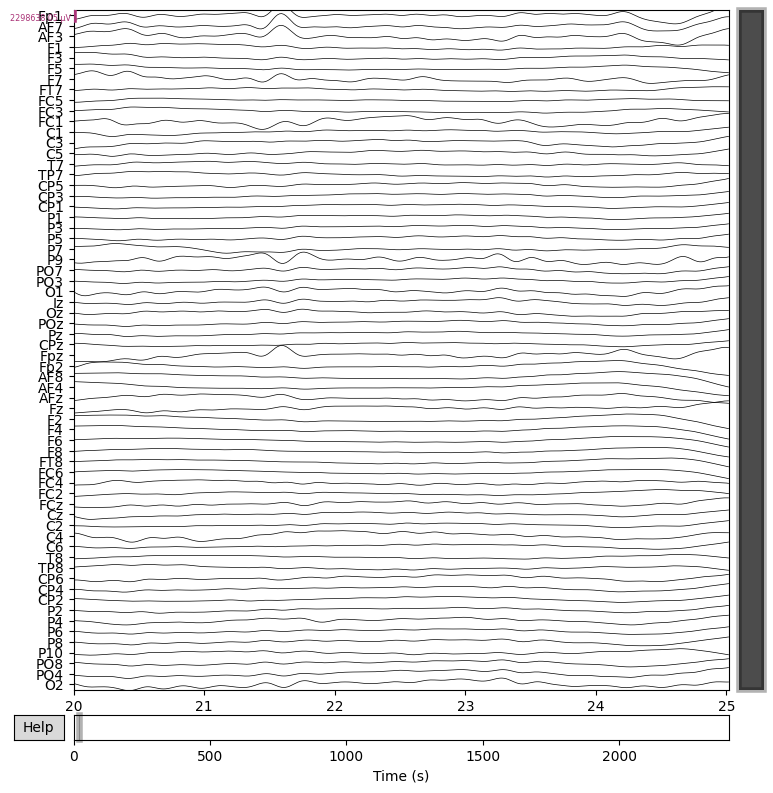

In [23]:
total_duration = raw.times[-1]
start_time = total_duration - 5
raw.plot(start = 20, duration=5, n_channels=64, scalings='auto')

In [38]:
# Aplicar filtrado con la ventana de Hamming
raw.filter(l_freq=0.5, h_freq=8, fir_design='firwin', fir_window='hamming')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawArray | 64 x 300000 (2400.0 s), ~146.6 MB, data loaded>

### STIM VISULAIZATION

In [16]:
envelope = dataset.stima
envelope.shape

torch.Size([153600])

In [17]:
envelope = stima_data

In [18]:
envelope[:64]  

array([ 0.00053309, -0.00110269,  0.00564936,  0.01871718,  0.01431248,
        0.01876585,  0.01662826,  0.01946833,  0.03817216,  0.04088281,
        0.04002726,  0.0434864 ,  0.03985877,  0.04269113,  0.03961981,
        0.04030421,  0.03949867,  0.04000035,  0.03979776,  0.04125089,
        0.03928741,  0.0386541 ,  0.03561674,  0.03656775,  0.03518008,
        0.0348848 ,  0.03464345,  0.03281922,  0.03254671,  0.0308901 ,
        0.0290706 ,  0.02952873,  0.02883402,  0.02866443,  0.02775759,
        0.02836354,  0.02723084,  0.02647014,  0.0270448 ,  0.02741588,
        0.02669665,  0.02716017,  0.0248791 ,  0.02402202,  0.02520036,
        0.02544626,  0.02382061,  0.0247835 ,  0.02361698,  0.02351119,
        0.02220297,  0.02308723,  0.02418303,  0.02418178,  0.02393421,
        0.02313036,  0.02369594,  0.02276023,  0.0227465 ,  0.02510675,
        0.02744117,  0.02927675,  0.03054375,  0.04548538])

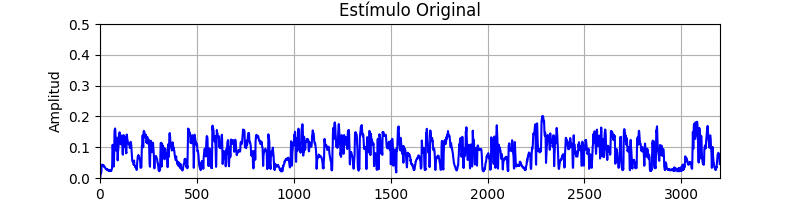

In [74]:
# Representar envolvente derecha
plt.figure(figsize=(8, 2))
plt.plot(envelope, color='Blue')
plt.title('Estímulo Original')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xlim([0, 50*64])
plt.ylim([0, 0.5])
plt.grid()
plt.show()

### HRTF VISUALIZATION

In [5]:
x = torch.randn((2, 3200))
x = torch.squeeze(x)
x.shape

torch.Size([2, 3200])

In [28]:
global_data_path

'C:/Users/jaulab/Desktop/AAD/Data'

In [39]:
os.path.exists(os.path.join(global_data_path, 'Fulsang_2017', 'HRTFs', subj+'_hrtf.mat'))

False

In [41]:
subj = 'S1'
hrtf_path = os.path.join(global_data_path, 'Fulsang_2017', 'HRTFs', subj+'_hrtfs.mat')
data = scipy.io.loadmat(hrtf_path)

In [141]:
att_wav = data['wavs'][:,0][0]['wavB'][0,0]
att_wav.shape

(3200, 2)

In [128]:
data_path = get_data_path(global_data_path, 'fulsang')
subj = 'S1'
preproc_data = scipy.io.loadmat(os.path.join(data_path ,subj + '_data_preproc.mat'))
stima_data = preproc_data['data']['wavA'][0,0][0,trials]
stima_data[0].shape

(3200, 1)

In [6]:
att_wav = data['wavs'][:,0][0]['wavB'][0,0]
att_wav.shape

NameError: name 'data' is not defined

In [ ]:
# Load from the Custom dataset
dataset ='fulsang'
data_path = get_data_path(global_data_path, dataset)
train_set = CustomDataset('fulsang', data_path, 'train', 'S1', window=128, hop=8, hrtf=True)

In [9]:
att_wav = train_set.stima
att_wav.shape

torch.Size([153600, 2])

In [15]:
# First trial
env_L = att_wav[1600:4800,0]
env_R = att_wav[1600:4800,1]
env_L.shape, env_R.shape

(torch.Size([3200]), torch.Size([3200]))

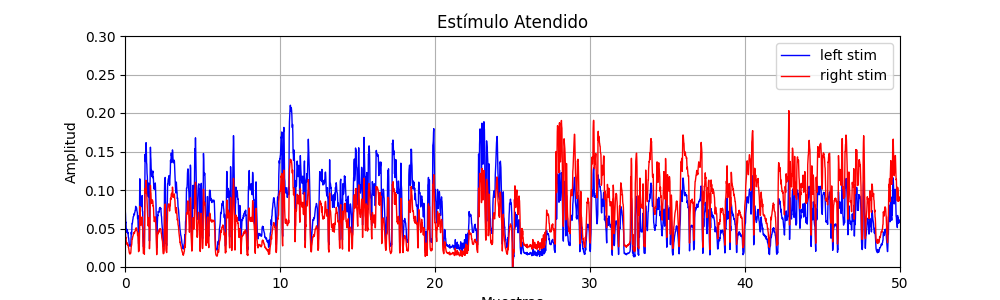

In [ ]:
# Representar envolvente derecha
x = np.arange(0, len(env_L)) / 64
plt.figure(figsize=(10, 3))
plt.plot(x, env_L, color='blue', linewidth=1, label='left stim')
plt.plot(x, env_R, color='red', linewidth=1, label='right stim')
plt.title('Estímulo Atendido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim([0, 50])
plt.ylim([0, 0.3])
plt.grid()
plt.legend()
plt.show()

En la gráfica se observa el cambio de posición de la fuente atendida reflejada en el cambio de dominancia en la señal a partir de los 25s al haber escogido 2 trials distintos.

In [ ]:
# Escenario donde prioriza 

## TORCH STACK VS TORCH VIEW

### TORCH VIEW

In [83]:
import torch

In [93]:
eeg = torch.randn((48, 64, 3200))
stima = torch.randn((48, 3200))
eeg.shape, stima.shape

(torch.Size([48, 64, 3200]), torch.Size([48, 3200]))

In [95]:
eeg[0,0,:20]

tensor([ 0.9058, -0.7303, -0.7819, -0.0534,  0.9283, -1.1002,  0.0673,  1.3093,
         2.2213, -1.5466,  0.6059, -0.0122, -0.8739,  1.1717, -0.7180,  0.3788,
        -0.0058, -1.3935, -0.3751,  1.2459])

In [96]:
stima[0,:20]

tensor([ 0.3259, -0.8756,  0.2687,  0.3264, -0.0306,  0.1277,  0.2319, -0.9652,
        -1.1888, -0.1164,  1.1225, -1.7293,  0.0452,  0.4111, -0.0043, -0.9332,
        -1.0006,  0.3696,  0.8481, -1.4191])

In [97]:
eeg_cat = eeg.view(eeg.shape[1], eeg.shape[0] * eeg.shape[2])
stima_cat = stima.view(-1)
eeg_cat.shape, stima_cat.shape

(torch.Size([64, 153600]), torch.Size([153600]))

In [98]:
eeg[0, :20]

tensor([ 0.9058, -0.7303, -0.7819, -0.0534,  0.9283, -1.1002,  0.0673,  1.3093,
         2.2213, -1.5466,  0.6059, -0.0122, -0.8739,  1.1717, -0.7180,  0.3788,
        -0.0058, -1.3935, -0.3751,  1.2459])

In [99]:
stima[:20]

tensor([ 0.3259, -0.8756,  0.2687,  0.3264, -0.0306,  0.1277,  0.2319, -0.9652,
        -1.1888, -0.1164,  1.1225, -1.7293,  0.0452,  0.4111, -0.0043, -0.9332,
        -1.0006,  0.3696,  0.8481, -1.4191])

### Bug loading data on dataset.py
En el dataset cuando se carga el eeg o el estímulo en fulsang, el modelo es capaz de entrenar correctamente sólo si se carga tanto eeg como estímulo utilizando la carga tradicional. Si se carga utilizando funciones .view de pytorch, el modelo deja de entrenarse correctamente. ¿A que se debe, es un fallo del tipo de datos o existe una diferencia en la concatención de datos cuando se utiliza hstack respecto de stack y luego view?

In [77]:
# Generate data
n_trials = 48
np.random.seed(1)
eeg_data = [np.random.randn(3200, 64) for n in range(n_trials)]
stima_data = [np.random.randn(3200, 1) for n in range(n_trials)]
eeg_data[0].shape, len(eeg_data), eeg_data[0].dtype, eeg_data[0][:5, 0]

((3200, 64),
 48,
 dtype('float64'),
 array([ 1.62434536,  0.48851815, -1.19926803,  1.90465871,  2.05117344]))

In [91]:
# Stack + view
eeg_data_cat = torch.stack([normalize_eeg(torch.tensor(eeg_data[trial]).T) for trial in range(n_trials)], dim=0)
eeg_data_cat = eeg_data_cat.view(eeg_data_cat.shape[1], eeg_data_cat.shape[0] * eeg_data_cat.shape[2])
eeg_data_cat.shape, eeg_data_cat[0,:5]

(torch.Size([64, 153600]),
 tensor([ 1.6896,  0.5250, -1.2055,  1.9770,  2.1272], dtype=torch.float64))

In [90]:
# Hstack
eeg_data_cat = torch.hstack([normalize_eeg(torch.tensor(eeg_data[trial]).T) for trial in range(n_trials)])
eeg_data_cat.shape, eeg_data_cat[0,:5]

(torch.Size([64, 153600]),
 tensor([ 1.6896,  0.5250, -1.2055,  1.9770,  2.1272], dtype=torch.float64))

In [89]:
# Stack + view
stima_data_cat = torch.squeeze(torch.tensor(np.stack(stima_data)))
stima_data_cat = stima_data_cat.view(-1)
stima_data_cat.shape, stima_data_cat[:5]

(torch.Size([153600]),
 tensor([-2.2720, -1.8724,  0.2086, -0.3089,  0.8754], dtype=torch.float64))

In [88]:
# Vstack
stima_data_cat = torch.squeeze(torch.vstack([torch.tensor(stima_data[trial]) for trial in range(n_trials)]))
stima_data_cat[:5], stima_data_cat.shape

(tensor([-2.2720, -1.8724,  0.2086, -0.3089,  0.8754], dtype=torch.float64),
 torch.Size([153600]))

El fallo en la simulación ocurre con el ajuste de datos de eeg cuando se realiza stack + view en vez de hstack aunque como se ha comprobado no tiene por que existir diferencia entre ambos métodos

## Ridge and CCA: sckit_learn functions

### Ridge CV function
Esta función realiza una regresión lineal utilizando la regularización l2 (alpha) e implementando una validación cruzada que si no se especifica resulta en una validación leave-one-out. La idea es compar el Ridge original del código con la función de scikit learn que incluye una validación cruzada para un modelo subject-specific con una 5-fold cv.

In [82]:
from utils.datasets import CustomDataset
from utils.functional import get_data_path
from models.ridge import Ridge
from sklearn.linear_model import RidgeCV
import torch
from scipy.linalg import toeplitz
from tqdm import tqdm

In [3]:
subject = 'S2'
dataset = 'fulsang'

In [4]:
# Carga de datos
window = 320
data_path = get_data_path(global_data_path, dataset)
train_set = CustomDataset(dataset, data_path, 'train', subject, 3200, 3200, unit_output=False)
val_set = CustomDataset(dataset, data_path, 'val', subject, 3200, 3200, unit_output=False)
test_set = CustomDataset(dataset, data_path, 'test', subject, window, window, unit_output=False)
train_set.eeg.shape, val_set.eeg.shape, test_set.eeg.shape, train_set.stima.shape, val_set.stima.shape, test_set.stima.shape

(torch.Size([64, 153600]),
 torch.Size([64, 19200]),
 torch.Size([64, 19200]),
 torch.Size([153600]),
 torch.Size([19200]),
 torch.Size([19200]))

In [5]:
alphas = np.logspace(-2, 10, 13)
alphas

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])

In [219]:
# New lagged function: Introduce a matrix of shape (C, T) and return a matrix (L*C, T)
def get_lagged_matrix(X, start_lag, end_lag):
    n_chan, n_times = X.shape
    n_lags = end_lag - start_lag
    lagged_matrix = np.zeros((n_chan * n_lags, n_times))
    if start_lag < 0:
        range = np.arange(end_lag, start_lag, -1)
    else:
        range = np.arange(start_lag, end_lag)

    for i, lag in enumerate(range):
        
        shifted_X = np.roll(X, shift=lag, axis=1)

        # Rellenamos los elementos desplazados con ceros según el signo de lag
        if lag > 0:
            shifted_X[:, :lag] = 0  # Zerofill beginning if lag > 0
        elif lag < 0:
            shifted_X[:, lag:] = 0  # Zerofill end if lag < 0

        # Insertamos el canal desplazado en su posición en la matriz lageada
        lagged_matrix[i * n_chan:(i + 1) * n_chan, :] = shifted_X

    return lagged_matrix

### Ridge original

In [6]:
# Cargo el modelo original
mdl = Ridge(start_lag=-25, end_lag=0, alpha = alphas)

In [7]:
# Train the model
mdl.fit(train_set.eeg.T, train_set.stima[:, np.newaxis])

Checking inputs...


Computing lagged matrix: 100%|██████████| 48/48 [00:02<00:00, 23.69it/s]


Computing autocorr_matrix...
Calculating coefficients...


Itenrating through alphas: 13it [00:01,  6.77it/s]


In [8]:
# Decoder shape with (alphas, output_feat, input_feat, time_lags)
# To predict the stim, this coefs are selected by each alpha and out dim, then they're 
# flattened to (T*L, 1) vector
mdl.coef_.shape 

(13, 1, 64, 25)

In [9]:
# Validate the model and select best alpha
scores = mdl.model_selection(val_set.eeg.T, val_set.stima[:, np.newaxis])
best_alpha = mdl.best_alpha_idx
print(f'Ridge trained for {dataset} data with a score of {scores[best_alpha]} with alpha = {best_alpha}')

Ridge trained for fulsang data with a score of 0.16519777872052394 with alpha = 4


In [10]:
len(test_set), test_set[0]['eeg'].shape

(59, torch.Size([64, 320]))

In [11]:
# Evaluate the model for each trial
att_corr = 0
scores_att = []
scores_unatt = []
for n, trial in enumerate(test_set):
    score_a = mdl.score(trial['eeg'].T, trial['stima'][:, np.newaxis])
    score_b = mdl.score(trial['eeg'].T, trial['stimb'][:, np.newaxis])
    if score_a > score_b: att_corr += 1
    scores_att.append(score_a), scores_unatt.append(score_b)
    if n >= len(test_set): break

print(f'Dec accuracy: {(att_corr / len(scores_att)) * 100} | corr mean: {np.mean(score_a)}')

Dec accuracy: 63.33333333333333 | corr mean: 0.3661702265384934


### Ridge sklearn

In [85]:
# for cross validating cat the train and val data
train_cv_set_eeg = torch.hstack((train_set.eeg, val_set.eeg))
train_cv_set_stima = torch.cat((train_set.stima, val_set.stima))
train_cv_set_stimb = torch.cat((train_set.stimb, val_set.stimb))
train_cv_set_eeg.shape, train_cv_set_stima.shape

(torch.Size([64, 172800]), torch.Size([172800]))

In [86]:
# Importar las métricas
from scipy.stats import pearsonr
from sklearn.metrics import make_scorer

In [32]:
x, y = torch.randn(3200), torch.randn(3200)
pearson_corr(x, y)

-0.03759372242314142

In [87]:
def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred).statistic

pearson_scorer = make_scorer(pearson_corr, greater_is_better=True)

In [88]:
# implement scikit_learn function with a 7-fold validation
model = RidgeCV(alphas, cv=7, scoring='neg_mean_squared_error')

In [13]:
train_cv_set_eeg.shape

NameError: name 'train_cv_set_eeg' is not defined

In [61]:
sim_eeg = np.random.randn(64,3200)
lag = get_lagged_matrix(sim_eeg, -25, 0)

In [66]:
lag.shape, lag[3][-10:]

((1600, 3200),
 array([-1.03526134, -0.72736798,  1.14598611,  1.09334456,  1.12925306,
         0.32337409,  0.68136466,  0.        ,  0.        ,  0.        ]))

In [123]:
# Parameters
start_lag = -25
end_lag = 0
n_chan, n_times = train_cv_set_eeg.size()
trial_len = 3200
n_trials = n_times // trial_len

In [125]:
for n in tqdm(range(n_trials), desc="Computing lagged matrix"):
    start = n * trial_len
    end = start + trial_len
    lagged_matrix = get_lagged_matrix(train_cv_set_eeg, -25, 0)
    # for ipf in range(input_feat):
    #     lagged_matrix[start:end, :, ipf] = get_lagged_matrix(X[start:end, ipf], start_lag, end_lag)
lagged_matrix.shape

Computing lagged matrix: 100%|██████████| 54/54 [01:09<00:00,  1.28s/it]


(1600, 172800)

In [126]:
lagged_matrix = np.transpose(lagged_matrix)
lagged_matrix.shape

(172800, 1600)

In [127]:
model.fit(lagged_matrix, train_cv_set_stima)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
        cv=7, scoring='neg_mean_squared_error')

In [128]:
model.alpha_

10000000.0

In [129]:
model.coef_.shape

(1600,)

In [133]:
start_lag, end_lag

(-25, 0)

In [134]:
# Evaluate the model for each trial
att_corr = 0
scores_att = []
scores_unatt = []
for n, trial in enumerate(test_set):
    # Compute the lagged matrix
    X = trial['eeg']
    # input_feat, n_times = X.size()
    lagged_trial = get_lagged_matrix(X, start_lag, end_lag)
    lagged_trial = np.transpose(lagged_trial)
    # lagged_trial = np.zeros((n_times, num_lags, input_feat))
    # for ipf in range(input_feat):
    #     lagged_trial[:, :, ipf] = get_lagged_matrix(X[:, ipf], start_lag, end_lag)
    # lagged_trial = np.reshape(lagged_trial, (n_times, num_lags*input_feat))
    print(trial['eeg'].shape, trial['stima'].shape, lagged_trial.shape)
    # score_a = model.score(lagged_trial, trial['stima'])
    # score_b = model.score(lagged_trial, trial['stimb'])
    score_a = pearson_corr(model.predict(lagged_trial), trial['stima'])
    score_b = pearson_corr(model.predict(lagged_trial), trial['stimb'])
    if score_a > score_b: att_corr += 1
    scores_att.append(score_a), scores_unatt.append(score_a)
    if n >= len(test_set): break
print(f'Dec accuracy: {(att_corr / len(scores_att)) * 100} | corr mean: {np.mean(score_a)}')

torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([64, 320]) torch.Size([320]) (320, 1600)
torch.Size([

In [67]:
# Diagonal + alpha como en skl con cholesky
A = np.zeros((16, 16))
A.flat[::16+1] += 1

In [68]:
import matplotlib.pyplot as plt

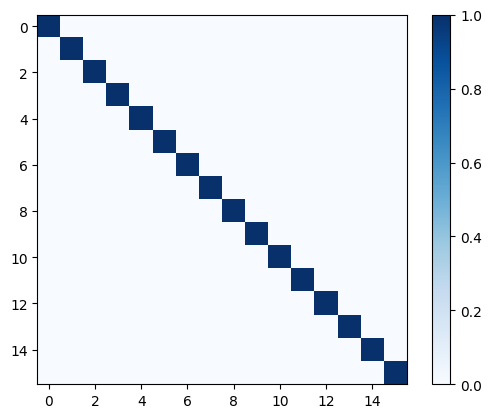

In [69]:
plt.imshow(A, cmap='Blues')
plt.colorbar()
plt.show()

## Canonical correlation analysis CCA
El método CCA que extrae dados una serie (trial) de EEG (3200x64) y de estímulo (3200x1) los vectores de pesos W1 (64, J) y W2 (1, J) que transforman los datos para que esten correlados al máximo posible. <br> 
Lo hacemos con una descomposición de vectores y valores propios de la matriz: XX(t) * XY * YY(t) * XX para el caso eeg siendo una matriz que resulta en 64x64 en el caso donde no se incluye lag. <br>
El valor propio máximo marca la correlación entre las dos fuentes de datos (EEG y estímulo). Queda por probar el valor de J el cual define el sub espacio en el que se proyectan los datos y que debe ser el mínimo de entre la dimensión de la envelope que viene dada por el delay y la longitud del encoder (1.25 segundos).
Para clasificar estos componentes se puede utilizar un clasificador LDA con la proyección de los datos que máximice la precisión del clasificador.

In [4]:
from utils.datasets import CustomDataset
from utils.functional import get_data_path
from scipy.linalg import toeplitz
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
subject = 'S2'
# subject = ['S'+str(n) for n in range(1, 9)]
dataset = 'fulsang'

In [8]:
# Carga de datos
window = 3200
data_path = get_data_path(global_data_path, dataset)
train_set = CustomDataset(dataset, data_path, 'train', subject, 3200, 3200, unit_output=False)
val_set = CustomDataset(dataset, data_path, 'val', subject, window, window, unit_output=False)
test_set = CustomDataset(dataset, data_path, 'test', subject, window, window, unit_output=False)
train_set.eeg.shape, val_set.eeg.shape, test_set.eeg.shape, train_set.stima.shape, val_set.stima.shape, test_set.stima.shape

(torch.Size([64, 153600]),
 torch.Size([64, 19200]),
 torch.Size([64, 19200]),
 torch.Size([153600]),
 torch.Size([19200]),
 torch.Size([19200]))

In [9]:
# New lagged function: Introduce a matrix of shape (C, T) and return a matrix (L*C, T)
def get_lagged_matrix(X, start_lag, end_lag):
    n_chan, n_times = X.shape
    n_lags = end_lag - start_lag
    lagged_matrix = np.zeros((n_chan * n_lags, n_times))
    # if start_lag < 0:
    #     range = np.arange(end_lag, start_lag, -1)
    # else:
    #     range = np.arange(start_lag, end_lag)
    range = np.arange(start_lag, end_lag)
    
    for i, lag in enumerate(range):
        
        shifted_X = np.roll(X, shift=lag, axis=1)

        # Rellenamos los elementos desplazados con ceros según el signo de lag
        if lag > 0:
            shifted_X[:, :lag] = 0  # Zerofill beginning if lag > 0
        elif lag < 0:
            shifted_X[:, lag:] = 0  # Zerofill end if lag < 0

        # Insertamos el canal desplazado en su posición en la matriz lageada
        lagged_matrix[i * n_chan:(i + 1) * n_chan, :] = shifted_X

    return lagged_matrix

### CCA implícito

In [69]:
# Conjunto de datos
train_set.eeg.shape, train_set.eeg.dtype, train_set.stima.shape, train_set.stima.dtype, val_set.eeg.shape, val_set.eeg.dtype, val_set.stima.shape, val_set.stima.dtype 

(torch.Size([64, 153600]),
 torch.float64,
 torch.Size([153600]),
 torch.float64,
 torch.Size([64, 19200]),
 torch.float64,
 torch.Size([19200]),
 torch.float64)

In [70]:
# Compute both lagged matrix
n_chan, n_times = train_set.eeg.shape
trial_len = 3200
n_trial = n_times // trial_len
lagged_eeg = np.zeros((n_chan*16, n_times))
lagged_stim = np.zeros((80, n_times))
for trial in range(n_trial):
    start = trial * trial_len
    end = (trial+1) * trial_len
    lagged_eeg[:,start:end] = get_lagged_matrix(train_set.eeg[:,start:end], start_lag=-16, end_lag=0) # 250 ms of post-stimulus lags on eeg decoder
    lagged_stim[:, start:end] = get_lagged_matrix(train_set.stima[np.newaxis,start:end], start_lag=0, end_lag=80) # 1.25s of post-stimulus lags on eeg decoder

In [71]:
lagged_eeg.shape, lagged_stim.shape

((1024, 153600), (80, 153600))

In [72]:
lagged_eeg[4,-10:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

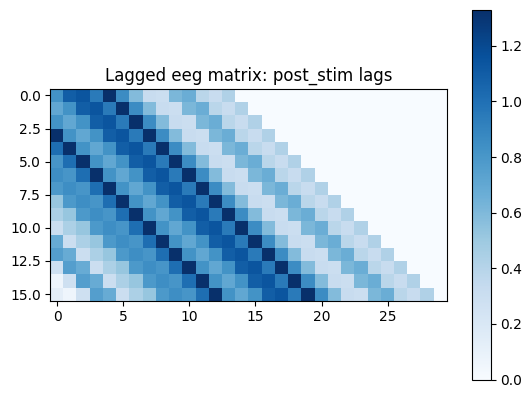

In [73]:
plt.imshow(lagged_eeg[::64][:,-30:], cmap='Blues')
plt.colorbar()
plt.title('Lagged eeg matrix: post_stim lags')
plt.show()

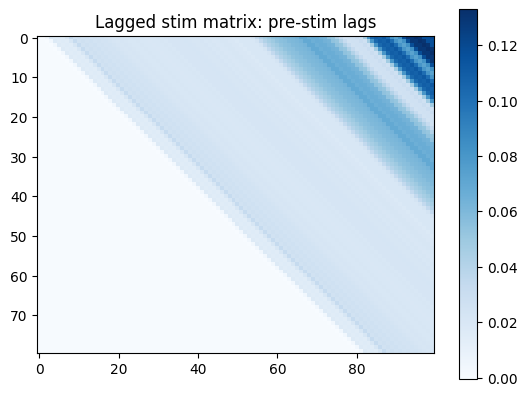

In [74]:
plt.imshow(lagged_stim[:,:100], cmap='Blues')
plt.colorbar()
plt.title('Lagged stim matrix: pre-stim lags')
plt.show()

In [76]:
# Estandarización de los datos
lagged_eeg = (lagged_eeg - lagged_eeg.mean(axis=1, keepdims=True)) / lagged_eeg.std(axis=1, keepdims=True)
lagged_stim = (lagged_stim - lagged_stim.mean(axis=1, keepdims=True)) / lagged_stim.std(axis=1, keepdims=True)

In [77]:
# Compute covariance matrices and
XtX = np.dot(lagged_eeg, lagged_eeg.T)
YtY = np.dot(lagged_stim, lagged_stim.T)
XtY = np.dot(lagged_eeg, lagged_stim.T)
YtX = np.dot(lagged_stim, lagged_eeg.T)

In [78]:
XtX.shape, YtY.shape, XtY.shape, YtX.shape

((1024, 1024), (80, 80), (1024, 80), (80, 1024))

In [86]:
from numpy.linalg import inv
from numpy.linalg import eigh
from numpy.linalg import svd
from scipy.stats import pearsonr

#### SVD

In [80]:
# Usar la descomposición de valores singulares (SVD) para encontrar combinaciones lineales
# Valores y vectores propios de la matriz 
eig_vals_X, eig_vecs_X = eigh(XtX)
eig_vals_Y, eig_vecs_Y = eigh(YtY)

In [83]:
# Valores para normalizar y transformar la matriz XtY
S_inv_X = np.dot(eig_vecs_X, np.diag(1.0/np.sqrt(eig_vals_X)))
S_inv_Y = np.dot(eig_vecs_Y, np.diag(1.0/np.sqrt(eig_vals_Y)))
T = np.dot(np.dot(S_inv_X.T, XtY), S_inv_Y)

In [84]:
T.shape

(1024, 80)

In [94]:
U, s, Vt = svd(T)

In [95]:
U.shape, Vt.shape, s.shape

((1024, 1024), (80, 80), (80,))

In [96]:
# Descomponer T para la obtención de los vectores conónicos
J = 16
Wx = U[:, :J]
Wy = Vt[:, :J]

### Eigen decomposition

In [18]:
# Compute the squared canonical correlation matrix for the decoder X
X_SCC = np.dot(inv(XtX), XtY)
print(X_SCC.shape)
X_SCC = np.dot(X_SCC, inv(YtY))
print(X_SCC.shape)
X_SCC = np.dot(X_SCC, YtX)
X_SCC.shape

(1024, 80)
(1024, 80)


(1024, 1024)

In [19]:
# Compute the squared canonical correlation matrix for the encoder Y
Y_SCC = np.dot(inv(YtY), YtX)
print(Y_SCC.shape)
Y_SCC = np.dot(Y_SCC, inv(XtX))
print(Y_SCC.shape)
Y_SCC = np.dot(Y_SCC, XtY)
Y_SCC.shape

(80, 1024)
(80, 1024)


(80, 80)

In [20]:
# Extract the eigenvalues and eigenvectors of the canonical components matrices
S_X, V_X = eigh(X_SCC)
S_Y, V_Y = eigh(Y_SCC)
S_X.shape, V_X.shape, S_Y.shape, V_Y.shape

((1024,), (1024, 1024), (80,), (80, 80))

In [21]:
S_X[:10], S_Y[:10]

(array([-0.08764653, -0.0635588 , -0.02539225, -0.01843899, -0.01487047,
        -0.01358073, -0.01169637, -0.01094975, -0.00960482, -0.00884115]),
 array([-1.34498674e-02, -4.00485731e-04, -2.66351055e-05,  5.38438384e-05,
         9.69617577e-05,  1.28258779e-04,  1.60628016e-04,  1.69680184e-04,
         1.77857340e-04,  1.89932695e-04]))

In [22]:
# Sort the eigenvalues and corresponding eigenvectors
sX_idx = np.argsort(S_X)[::-1]
S_X = S_X[sX_idx]
sY_idx = np.argsort(S_Y)[::-1]
S_Y = S_Y[sY_idx]
S_X[:10], S_Y[:10]

(array([0.10350435, 0.08178057, 0.02908198, 0.02103364, 0.0160712 ,
        0.01514486, 0.01321612, 0.01189521, 0.01016671, 0.00850166]),
 array([0.02755606, 0.0159283 , 0.0066203 , 0.00412747, 0.00323487,
        0.00279761, 0.00203325, 0.00168466, 0.00135067, 0.00122752]))

In [23]:
# Select the J correlation coefficients and validate their correlation
J = 16
Wx = V_X[:, :J]
Wy = V_Y[:, :J]
Wy.shape, Wx.shape

((80, 16), (1024, 16))

### Applying weights

In [97]:
# Validate coefficients showing correlation
n_trials = len(train_set)
scores_a = np.zeros((n_trials, J))
scores_b = np.zeros((n_trials, J))

for n, trial in enumerate(train_set):

    if n >= len(train_set): break
    
    # Compute the lagged matrix
    eeg = trial['eeg']
    stima = trial['stima']
    stimb = trial['stimb']

    lagged_eeg = get_lagged_matrix(eeg, -16, 0)
    lagged_stima = get_lagged_matrix(stima[np.newaxis, :], 0, 80)
    lagged_stimb = get_lagged_matrix(stimb[np.newaxis, :], 0, 80)
    # print(trial['eeg'].shape, trial['stima'].shape, lagged_eeg.shape, lagged_stima.shape)

    eeg_proj = np.dot(Wx.T, lagged_eeg)
    stima_proj = np.dot(Wy.T, lagged_stima)
    stimb_proj = np.dot(Wy.T, lagged_stimb)

    scores_a[n, :] = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])
    scores_b[n, :] = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])

    scores_a[n, :] = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] - pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])
    scores_b[n, :] = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] - pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])
    
    # score_a = [pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)]
    # uncorr_a = [pearsonr(eeg_proj[j], eeg_proj[j+1])[0] for j in range(J-1)]
    # score_b = [pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)]
    # f = [corr_a - corr_b for corr_a, corr_b in zip(score_a, score_b)]

    # # Observe the correlation
    # print([f'{score:.3f}' for score in score_a])
    # print([f'{score:.3f}' for score in uncorr_a])
    # print([f'{score:.3f}' for score in score_b])
    # print([f'{score:.3f}' for score in f])
    # att_correct = 0
    # for corr_a, corr_b in zip(score_a, score_b):
    #     if corr_a > corr_b: att_correct += 1
    # print(att_correct)
    
    
# print(f'Dec accuracy: {(att_corr / len(scores_att)) * 100} | corr mean: {np.mean(score_a)}')

In [98]:
scores_a.shape, scores_b.shape

((47, 16), (47, 16))

Hasta aquí hemos proyectado tanto el EEG como el estímulo, en un sub-espacio J donde las señales estan correladas entre sí. Una vez obtenemos estos vectores de correlación, entrenamos un linear discriminant classifier (LDA) para clasificar estas correlaciones entre señal attendida y no atendida. 

In [99]:
# Definición LDA: a la entrada tenemos una serie de correlaciones resultantes de la proyección CCA
# de dimensión (n_smaples, n_feat). El clasificador supervisado se entrena con la correlaciones atendidas (y=1)
# y con las no atendidas (y=0).

def lda_fit(X, y):

    class_labels = np.unique(y) # etiquetas de cada clase (0:no atendida y 1:atendida)
    mean_overall = np.mean(X, axis=0)

    # Scatter/matriz de dispersión dentro de las clases: mide la dispersión de datos dentro de la clase
    # Cabe esperar un valor elevado ya que la varianza dentro de las clases es elevada
    S_W = np.zeros((X.shape[1], X.shape[1]))
    # Scatter/matriz de dispersión entre clases: mide como las medias de distintas clases están separadas entre sí
    # Cabe esperar un valor bajo ya que las distribuciones de correlación atendida y no atendida obtienen valores similares por lo tanto medias similares
    S_B = np.zeros((X.shape[1], X.shape[1]))

    # Calcular las matrices de dispersión
    for label in class_labels:
        X_c = X[y == label] # subconjunto de la clase actual
        mean_c = np.mean(X_c, axis=0)
        S_W += np.dot((X_c - mean_c).T, (X_c - mean_c)) # Suma dentro de las clases
        n_c = X_c.shape[0]
        mean_diff = (mean_c - mean_overall).reshape(-1,1)
        S_B += n_c * np.dot(mean_diff, mean_diff.T) # Suma entre clases

    # Resolver el problema de valores propios para la matriz S_W^(-1) * S_B
    eig_vals, eig_vect = eigh(np.dot(inv(S_W), S_B))

    sorted_indices = np.argsort(eig_vals)[::-1]
    eig_vecs = eig_vect[:, sorted_indices]

    # Seleccionar los primeros vectores (dimensionalidad <= n_clases - 1)
    # En este caso seleccionar el primero y único
    W = eig_vecs[:, 1] # Proyección espacio LDA para proyectar correlaciones en las clases (J, 1)

    return W

def lda_transform(X, W):
     return np.dot(X, W)

In [100]:
scores = np.vstack((scores_a, scores_b))
labels = np.concatenate((np.ones(scores_a.shape[0]), np.zeros(scores_b.shape[0])))
scores[47], scores_b[0], labels[:5], labels[-5:], labels.shape, scores.shape

(array([-1.83281010e-02, -5.14455479e-03,  3.01482857e-06,  2.78738589e-02,
         4.70152052e-02, -3.74374243e-02, -1.30711856e-02,  1.12117280e-01,
        -4.92272231e-02, -2.89083218e-02, -9.74279745e-02,  6.06021215e-02,
         3.80176497e-02, -6.24727228e-03,  1.89738148e-02, -1.57336079e-01]),
 array([-1.83281010e-02, -5.14455479e-03,  3.01482857e-06,  2.78738589e-02,
         4.70152052e-02, -3.74374243e-02, -1.30711856e-02,  1.12117280e-01,
        -4.92272231e-02, -2.89083218e-02, -9.74279745e-02,  6.06021215e-02,
         3.80176497e-02, -6.24727228e-03,  1.89738148e-02, -1.57336079e-01]),
 array([1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0.]),
 (94,),
 (94, 16))

In [101]:
LDA = lda_fit(scores, labels)
LDA.shape

(16,)

In [102]:
# Hallar el umbral basado en la media de clases
scores_projected = lda_transform(scores, LDA)
mean_att = scores_projected[labels == 1].mean()
mean_unatt = scores_projected[labels == 0].mean()
threshold = (mean_att + mean_unatt) / 2
mean_att, mean_unatt, threshold

(0.010431377380980628, -0.010431377380980628, 0.0)

In [104]:
# Validate the model
att_corr = 0
unatt_corr = 0
for n, trial in enumerate(val_set):

    if n >= len(val_set): break
    
    # Compute the lagged matrix
    eeg = trial['eeg']
    stima = trial['stima']
    stimb = trial['stimb']

    lagged_eeg = get_lagged_matrix(eeg, -16, 0)
    lagged_stima = get_lagged_matrix(stima[np.newaxis, :], 0, 80)
    lagged_stimb = get_lagged_matrix(stimb[np.newaxis, :], 0, 80)
    # print(trial['eeg'].shape, trial['stima'].shape, lagged_eeg.shape, lagged_stima.shape)

    eeg_proj = np.dot(Wx.T, lagged_eeg)
    stima_proj = np.dot(Wy.T, lagged_stima)
    stimb_proj = np.dot(Wy.T, lagged_stimb)

    scores_att = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])
    scores_unatt = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])

    # if lda_transform(scores_att, LDA) > threshold: att_corr +=1
    # if lda_transform(scores_unatt, LDA) < threshold: unatt_corr +=1
    if lda_transform(scores_att, LDA) > lda_transform(scores_unatt, LDA): att_corr +=1

print(f'Dec Att: {att_corr / len(val_set) * 100} | Dec Unatt: {unatt_corr / len(val_set) * 100}')

Dec Att: 60.0 | Dec Unatt: 0.0


### CCA sklearn

In [34]:
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import pearsonr

In [19]:
# Compute both lagged matrix
n_chan, n_times = train_set.eeg.shape
trial_len = 3200
n_trial = n_times // trial_len
lagged_eeg = np.zeros((n_chan*16, n_times))
lagged_stim = np.zeros((80, n_times))
for trial in range(n_trial):
    start = trial * trial_len
    end = (trial+1) * trial_len
    lagged_eeg[:,start:end] = get_lagged_matrix(train_set.eeg[:,start:end], start_lag=-16, end_lag=0) # 250 ms of post-stimulus lags on eeg decoder
    lagged_stim[:, start:end] = get_lagged_matrix(train_set.stima[np.newaxis,start:end], start_lag=0, end_lag=80) # 1.25s of post-stimulus lags on eeg decoder

In [20]:
lagged_eeg.shape, lagged_stim.shape

((1024, 153600), (80, 153600))

In [21]:
model = CCA(n_components=16)

In [22]:
model.fit(lagged_eeg.T, lagged_stim.T)

CCA(n_components=16)

In [64]:
# Validate coefficients showing correlation
J = 16
n_trials = len(train_set)
scores_a = np.zeros((n_trials, J))
scores_b = np.zeros((n_trials, J))

for n, trial in enumerate(train_set):

    if n >= len(train_set): break
    
    # Compute the lagged matrix
    eeg = trial['eeg']
    stima = trial['stima']
    stimb = trial['stimb']

    lagged_eeg = get_lagged_matrix(eeg, -16, 0)
    lagged_stima = get_lagged_matrix(stima[np.newaxis, :], 0, 80)
    lagged_stimb = get_lagged_matrix(stimb[np.newaxis, :], 0, 80)
    # print(trial['eeg'].shape, trial['stima'].shape, lagged_eeg.shape, lagged_stima.shape)

    # eeg_proj = np.dot(Wx.T, lagged_eeg)
    # stima_proj = np.dot(Wy.T, lagged_stima)
    # stimb_proj = np.dot(Wy.T, lagged_stimb)
    eeg_proj, stima_proj  = model.transform(lagged_eeg.T, lagged_stima.T)
    eeg_proj, stimb_proj  = model.transform(lagged_eeg.T, lagged_stimb.T)

    eeg_proj, stima_proj, stimb_proj = eeg_proj.T, stima_proj.T, stimb_proj.T

    # scores_a[n, :] = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])
    # scores_b[n, :] = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])

    # scores_a[n, :] = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] - pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])
    # scores_b[n, :] = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] - pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])

    score_a = [pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)]
    uncorr_a = [pearsonr(eeg_proj[j], eeg_proj[j+1])[0] for j in range(J-1)]
    score_b = [pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)]
    f = [corr_a - corr_b for corr_a, corr_b in zip(score_a, score_b)]

    # Observe the correlation
    print([f'{score:.3f}' for score in score_a])
    print([f'{score:.3f}' for score in uncorr_a])
    print([f'{score:.3f}' for score in score_b])
    print([f'{score:.3f}' for score in f])
    att_correct = 0
    for corr_a, corr_b in zip(score_a, score_b):
        if corr_a > corr_b: att_correct += 1
    print(att_correct)

['0.266', '0.248', '0.226', '0.102', '0.109', '0.162', '0.128', '0.123', '0.110', '0.083', '0.051', '0.099', '0.063', '0.044', '0.045', '0.048']
['0.025', '-0.095', '0.067', '-0.011', '-0.035', '-0.034', '-0.029', '0.002', '-0.008', '0.005', '-0.000', '0.040', '0.033', '0.011', '-0.026']
['0.060', '0.059', '0.069', '-0.027', '0.010', '0.027', '0.007', '0.004', '-0.006', '0.004', '-0.020', '-0.047', '-0.018', '-0.005', '-0.023', '-0.023']
['0.206', '0.188', '0.157', '0.130', '0.099', '0.135', '0.121', '0.119', '0.116', '0.078', '0.071', '0.146', '0.081', '0.049', '0.068', '0.071']
16
['0.165', '0.185', '0.067', '0.149', '0.109', '0.103', '0.113', '0.063', '0.123', '0.100', '0.092', '0.104', '0.082', '0.081', '0.100', '0.096']
['0.147', '-0.051', '0.017', '0.006', '-0.038', '-0.007', '-0.074', '-0.015', '0.005', '0.031', '0.012', '0.016', '0.016', '0.010', '0.022']
['0.088', '0.146', '0.056', '0.018', '0.025', '0.020', '-0.021', '-0.003', '-0.004', '0.007', '-0.005', '0.006', '-0.038', '

In [39]:
scores = np.vstack((scores_a, scores_b))
labels = np.concatenate((np.ones(scores_a.shape[0]), np.zeros(scores_b.shape[0])))
labels.shape, scores.shape

((94,), (94, 16))

In [40]:
classifier = LinearDiscriminantAnalysis()
classifier.fit(scores, labels)

LinearDiscriminantAnalysis()

In [41]:
# Hallar el umbral basado en la media de clases
scores_projected = classifier.transform(scores)
mean_att = scores_projected[labels == 1].mean()
mean_unatt = scores_projected[labels == 0].mean()
threshold = (mean_att + mean_unatt) / 2
mean_att, mean_unatt, threshold

(4.639983318347451, -4.639983318347451, 0.0)

In [45]:
scores.shape, scores_projected.shape

((94, 16), (94, 1))

In [63]:
# Validate the model
att_corr = 0
unatt_corr = 0
for n, trial in enumerate(val_set):

    if n >= len(val_set): break
    
    # Compute the lagged matrix
    eeg = trial['eeg']
    stima = trial['stima']
    stimb = trial['stimb']

    lagged_eeg = get_lagged_matrix(eeg, -16, 0)
    lagged_stima = get_lagged_matrix(stima[np.newaxis, :], 0, 80)
    lagged_stimb = get_lagged_matrix(stimb[np.newaxis, :], 0, 80)
    # print(trial['eeg'].shape, trial['stima'].shape, lagged_eeg.shape, lagged_stima.shape)

    eeg_proj, stima_proj  = model.transform(lagged_eeg.T, lagged_stima.T)
    eeg_proj, stimb_proj  = model.transform(lagged_eeg.T, lagged_stimb.T)

    eeg_proj, stima_proj, stimb_proj = eeg_proj.T, stima_proj.T, stimb_proj.T

    scores_att = np.array([pearsonr(eeg_proj[j], stima_proj[j])[0] for j in range(J)])
    scores_unatt = np.array([pearsonr(eeg_proj[j], stimb_proj[j])[0] for j in range(J)])

    scores_att = scores_att.reshape(1, -1)
    scores_unatt = scores_unatt.reshape(1, -1)

    # if classifier.transform(scores_att) > threshold: att_corr +=1
    # if classifier.transform(scores_unatt) < threshold: unatt_corr +=1
    if classifier.transform(scores_att) > classifier.transform(scores_unatt): att_corr +=1

print(f'Dec Att: {att_corr / len(val_set) * 100} | Dec Unatt: {unatt_corr / len(val_set) * 100}')

Dec Att: 80.0 | Dec Unatt: 0.0


In [61]:
scores_att

array([[ 0.09729247,  0.09873472, -0.07094762,  0.09867445,  0.11047514,
         0.04335861,  0.05355934,  0.03429573, -0.05641655, -0.07046149,
        -0.03577175, -0.0250085 ,  0.01470592,  0.01040238,  0.02128904,
        -0.00099524]])

In [58]:
array = np.random.randn(16)
array.reshape(1, -1).shape

(1, 16)

## MESD